## <center>Support Vector Machine</center>

In [5]:
# Import libraries
import sys
sys.path.append("..")

import numpy as np
import cvxopt
cvxopt.solvers.options['show_progress'] = False

from utils import euclidean_distance, accuracy_score
from utils import train_test_split, normalize, Plot
from utils.kernels import *

In [6]:
class SVM:
    """The Support Vector Machine Classifier
    Uses cvxopt to solve the quadratic optimization problem
    
    Parameters:
    -----------
    C: float
        Penalty term
    
    kernel: function
        polynomial, rbf, linear
    
    power: int
        The degree of for polynomial kernel, ignore for others.
    
    gamma: float
        Used in rbf kernel function.
    
    coef: float
        Bias term used in polynomial kernel.
    """
    
    def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None
        
        
    def fit(self, X, y):
        n_samples, n_features = np.shape(X)
        
        if not self.gamma:
            self.gamma = 1/n_features
        
        # Initialize the kernel function
        self.kernel = self.kernel(power = self.power,
                                 gamma = self.gamma,
                                 coef = self.coef)
        
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i,j] = self.kernel(X[i], X[j])
        
        #Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')
        
        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Lagrange multiplier
        lagr_mult = np.ravel(minimization['x'])
        
        # Extract support vectors
        # Get index of non zero lagr. multipliers
        idx = lagr_mult > 1e-7
        
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        
        # Get the corresponding labels
        self.support_vector_labels = y[idx]
        
        # Calculate the intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], self.support_vectors[0])
            
    
    def predict(self, X):
        y_pred = []
        
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            
            # Determine the label of sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], sample)
                
                
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

### Test 

Accuracy:  0.5172413793103449


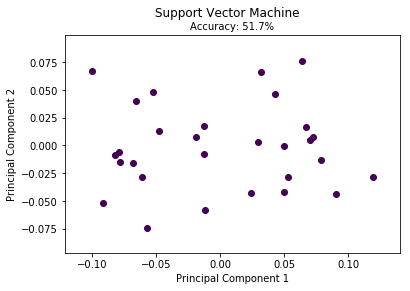

In [7]:
def main():
    from sklearn import datasets
    data = datasets.load_iris()
    X = normalize(data.data[data.target != 0])
    y = data.target[data.target != 0]
    y[y==1] = -1
    y[y==2] = 1
    #X = normalize(data.data)
    y = data.target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    clf = SVM(kernel = polynomial_kernel, power = 4, coef = 1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Accuracy: ", accuracy)
    
    # Reduce dimension to 2 using PCA and plot the results
    Plot().plot_in_2d(X_test, y_pred, title = "Support Vector Machine", accuracy = accuracy)

if __name__ == "__main__":
    main()
    